# Training of Full U-Net Model

The final scripts puts together all parts of the previous scripts. I will use pytorch lightning to organize the training of the U-Net model, based on heavily augmented data. 

In [7]:
from pathlib import Path

# Import pytorch and pytorch lightning as pl
# pl helps to organize the training and distribute it on GPUs
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint # To save the model at various checkpoints and load it later 
from pytorch_lightning.loggers import TensorBoardLogger # So we can use tensorboard for a nice visualization of the training

# Import the Full U-Net
from model import UNet_Full

# Import the dataset
from dataset import HistologyDataset
import imgaug.augmenters as iaa # For data augmentation

import numpy as np 
import matplotlib.pyplot as plt
from skimage.measure import label as sklabel # To count the labels and the predictions 

from tqdm.notebook import tqdm


In [8]:
# Again, define the data augmentation steps
seq = iaa.Sequential([
        iaa.LinearContrast((0.5, 1.5)), 
        iaa.Multiply((0.5, 1.5), per_channel=0.2),
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5), 
        iaa.Affine(scale=(0.90, 1.10), # Random Scaling of the image
                        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # Random Translation 
                        rotate=(-45, 45),# Random rotation up to 45deg
                        shear=(-15, 15)),  # Random shear
        iaa.ElasticTransformation()  # Random Elastic Deformations
                ])

In [9]:
# Create the dataset objects
train_path = Path("preprocessed/train/")
val_path = Path("preprocessed/val")

train_dataset = HistologyDataset(train_path, seq)
# The validation dataset does not require data augmentation
val_dataset = HistologyDataset(val_path, None)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 22 train images and 6 val images


Now, we define the train and validation loader. This is done using the pytorch function  DataLoader

In [10]:
batch_size = 8
num_workers = 4

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)


With all this in place, we can now define the training model

In [11]:
class HistoNucleiSegmentation(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        # We will use the full U-Net
        self.model = UNet_Full()
        
        # Standard pytorch Adam Optimizer
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        
        # For classification purposes, we will use the binary cross entropy
        self.loss_fn = torch.nn.BCELoss()
        
    def forward(self, data):
        # The forward step includes taking a sigmoid function of the model output
        return torch.sigmoid(self.model(data))
    
    def training_step(self, batch, batch_idx):
        # Extract batch data and get train img and mask 
        img, mask = batch
        
        # The mask is converted to float for training purposes
        mask = mask.float()
        
        # Prediction step
        pred = self(img)
        
        # Calculate BCE Loss between prediction and label
        loss = self.loss_fn(pred, mask)
        
        # Log the current loss value
        self.log("Train BCE", loss)
        
        # Every 50 images, run the log_images function using the img, prediction and label
        if batch_idx % 50 == 0:
            self.log_images(img.cpu(), pred.cpu(), mask.cpu(), "Train")
            
        return loss
    
    def validation_step(self, batch, batch_idx):
        # Same steps as during training, but on validation data
        img, mask = batch
        mask = mask.float()
        pred = self(img)
        
        loss = self.loss_fn(pred, mask)
        
        self.log("Val BCE", loss)
        
        if batch_idx % 2 == 0:
            self.log_images(img.cpu(), pred.cpu(), mask.cpu(), "Val")
            
        return loss
    
    
    def log_images(self, img, pred, mask, name):
        
        # Threshold prediction
        pred = pred > 0.5
                
        # Remove pytorch batch dimension
        img = img[0,...]
        
        # Take mean across color channels and normalize to [0,1]
        img = img.mean(axis = 0)
        img = (img - img.min()) / img.max()
        
        # Plot the img, pred and label
        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(img, cmap="gray")
        axis[0].contour(mask[0][0])
        axis[0].set_title('Label')
        
        axis[1].imshow(img, cmap="gray")
        axis[1].contour(pred[0][0])
        axis[1].set_title('Prediction')
        
        # Add figure to the experiment logger
        self.logger.experiment.add_figure(name, fig, self.global_step)
        
    def configure_optimizers(self):
        # The optimizer needs to be returned in a list
        return [self.optimizer]

In [12]:
# Instanciate the model and set a random seed
torch.manual_seed(0)
model = HistoNucleiSegmentation()

In [13]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val BCE',
    save_top_k=10,
    mode='min')

In [14]:
gpus = 0 # Pytorch Lightning handles the use of gpus during training. 
# Unfortunately, I was running this on my laptop. So I had to turn off the gpu
trainer = pl.Trainer(gpus=gpus, logger=TensorBoardLogger(save_dir="./logs"), log_every_n_steps=1,
                     callbacks=checkpoint_callback,max_epochs=75)


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/cornelius/miniconda3/envs/pytorchenv/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1304: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  "GPU available but not used. Set the gpus flag in your trainer"


In [11]:
trainer.fit(model, train_loader, val_loader)


  | Name    | Type      | Params
--------------------------------------
0 | model   | UNet_Full | 31.4 M
1 | loss_fn | BCELoss   | 0     
--------------------------------------
31.4 M    Trainable params
0         Non-trainable params
31.4 M    Total params
125.516   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/cornelius/miniconda3/envs/pytorchenv/lib/python3.7/site-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/home/cornelius/miniconda3/envs/pytorchenv/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: No contour levels were found within the data range.


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [15]:
PreSavedModel = HistoNucleiSegmentation.load_from_checkpoint('logs/default/version_0/checkpoints/epoch=74-step=224.ckpt')

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model.eval();
model.to(device);
print('Device: {}'.format(str(device)))

Device: cpu


In [18]:
preds = []
labels = []
imgs = []
# Loop over validation dataset
for img, label in tqdm(val_dataset):
    # extracted img needs to be expanded to accomodate batch dimension of model
    img = torch.tensor(img).to(device).unsqueeze(0)
    with torch.no_grad():
        pred = PreSavedModel(img)
    preds.append(pred.cpu().numpy())
    labels.append(label)
    imgs.append(img.numpy().squeeze())
    
preds = np.array(preds).squeeze()
labels = np.array(labels).squeeze()
imgs = np.array(imgs).transpose((0,2,3,1))

  0%|          | 0/6 [00:00<?, ?it/s]

/home/cornelius/miniconda3/envs/pytorchenv/lib/python3.7/site-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


  0%|          | 0/6 [00:00<?, ?it/s]

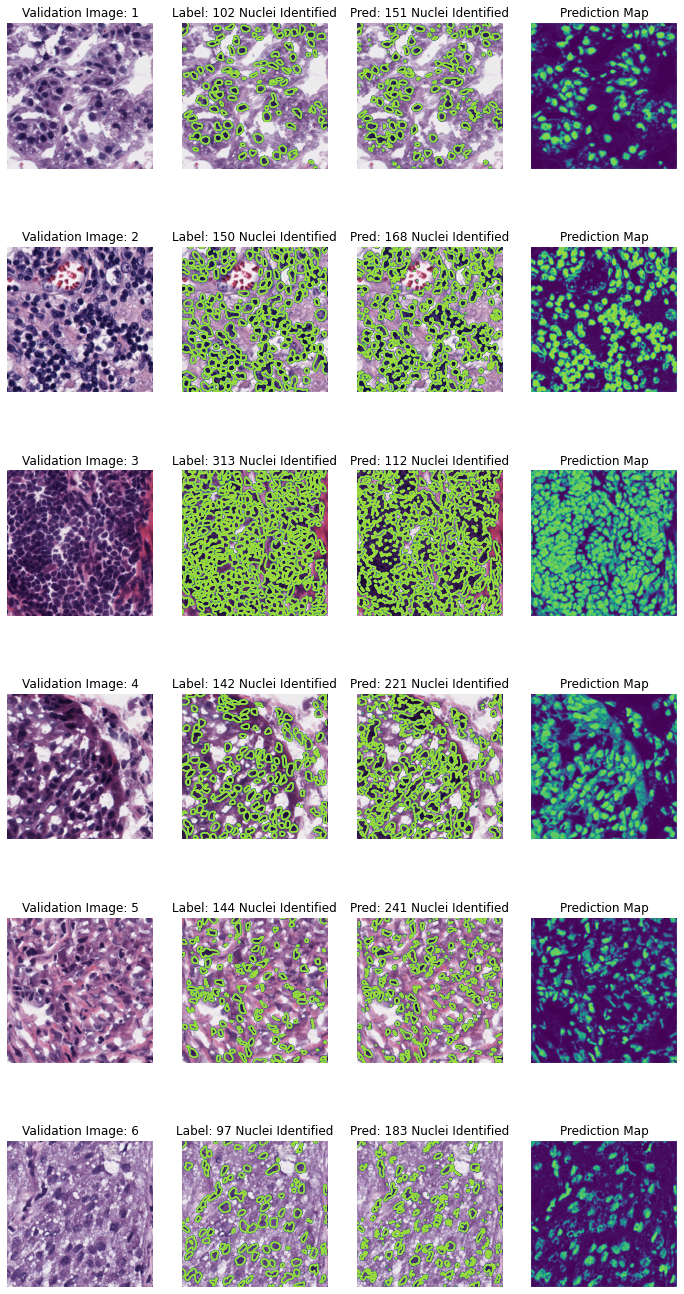

In [24]:
from functions import un_standardize

# Sample means and stds for un_normalization
means = np.array([0.53955701, 0.38888616, 0.56235658])
stds = np.array([0.21415865, 0.2144178,  0.16906027])

# Emply lists to compare numbers of nuclei segmentations
n_nuclei_label = []
n_nuclei_pred = []



fig, axis = plt.subplots(6, 4, figsize=(12, 24))

for i_val in tqdm(range(labels.shape[0])):
    
    ###
    # Plot the raw image
    axis[i_val][0].imshow(un_standardize(imgs[i_val], means, stds))
    axis[i_val][0].axis("off")
    axis[i_val][0].set_title('Validation Image: {}'.format(i_val + 1))
    
    
    
    ###
    # Plot image with label segmentations
    
    # Identify label clusters
    label_identified_nuclei = sklabel(labels[i_val], connectivity=1, background = 0)
    
    # Count clusters and append to list
    n_label_identified_nuclei = len(np.unique(label_identified_nuclei[label_identified_nuclei > 0]))
    n_nuclei_label.append(n_label_identified_nuclei)
    
    # Make plot
    axis[i_val][1].imshow(un_standardize(imgs[i_val], means, stds))
    axis[i_val][1].contour(labels[i_val])
    axis[i_val][1].set_title('Label: {} Nuclei Identified'.format(n_label_identified_nuclei))
    axis[i_val][1].axis("off")

    
    ###
    # Plot image with model prediction segmentations
    
    # Apply threshold of 0.5 
    tmp_pred = preds[i_val] > 0.5
    
    # Identify pred sementations clusters
    pred_identified_nuclei = sklabel(tmp_pred, connectivity=1, background = 0)
    
    # Count prediction clusters and append to list
    n_pred_identified_nuclei = len(np.unique(pred_identified_nuclei[pred_identified_nuclei > 0]))
    n_nuclei_pred.append(n_pred_identified_nuclei)
    
    axis[i_val][2].imshow(un_standardize(imgs[i_val], means, stds))
    axis[i_val][2].contour(tmp_pred)
    axis[i_val][2].set_title('Pred: {} Nuclei Identified'.format(n_pred_identified_nuclei))
    axis[i_val][2].axis("off")
    
    ###
    # Plot prediction map unthresholded
    tmp_im = axis[i_val][3].imshow(preds[i_val], vmin = 0, vmax = 1, cmap = 'viridis')
    axis[i_val][3].set_title('Prediction Map')
    axis[i_val][3].axis("off")

# Convert lists to numpy arrays and concatenate
n_nuclei_compare = np.array([
    np.array(n_nuclei_label),
    np.array(n_nuclei_pred)
])

In [25]:
percentage_off = np.mean(np.abs(n_nuclei_compare[0] - n_nuclei_compare[1]) / n_nuclei_compare[0])

print('Average Percentage of Devition between n Nuclei Label and Pred = {:.2f} %'.format(100 * percentage_off))

Average Percentage of Devition between n Nuclei Label and Pred = 55.99 %


In [26]:
from functions import confusion_matrix

_ = confusion_matrix(labels, preds>0.5, print_tab = True)

               Pred TRUE 	 Pred FALSE
Label TRUE  	 0.22 	 	 0.05 	 	 0.26
Label FALSE 	 0.06 	 	 0.68 	 	 0.74
                 0.28 		 0.72 


Small U-Net has lower false positive rate (0.04 vs 0.06)
Full U-Net has lower false negative rate (0.05 vs 0.06)

I see no major difference in model performance between full U-Net and the small U-Net